[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/notebooks/pgame_example.ipynb)

# Optimizing with MEES in Jax

This notebook shows how to use QDax to find diverse and performing controllers with MAP-Elites-ES introduced in [Scaling MAP-Elites to Deep Neuroevolution](https://dl.acm.org/doi/pdf/10.1145/3377930.3390217).
It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create the MEES emitter
- how to create a Map-elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualize the results of the training process

In [8]:
#@title Installs and Imports
!pip install ipympl |tail -n 1
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager()

import os

from IPython.display import clear_output
import functools
import time

import jax
import jax.numpy as jnp

try:
    import brax
except:
    !pip install git+https://github.com/google/brax.git@v0.0.12 |tail -n 1
    import brax

try:
    import qdax
except:
    !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@feat/add-algo-mees |tail -n 1
    import qdax


from qdax.core.map_elites import MAPElites
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids
from qdax import environments
from qdax.core.neuroevolution.mdp_utils import scoring_function
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.utils.plotting import plot_map_elites_results

from qdax.core.emitters.mees_emitter import MEESConfig, MEESEmitter
from qdax.utils.metrics import CSVLogger, default_qd_metrics


if "COLAB_TPU_ADDR" in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

clear_output()

In [9]:
#@title QD Training Definitions Fields
#@markdown ---
env_name = 'walker2d_uni'#@param['walker2d_uni', 'ant_uni', 'hopper_uni', 'walker_uni', 'halfcheetah_uni', 'humanoid_uni', 'ant_omni', 'humanoid_omni']
episode_length = 100 #@param {type:"integer"}
num_iterations = 100 #@param {type:"integer"}
seed = 42 #@param {type:"integer"}
policy_hidden_layer_sizes = (64, 64) #@param {type:"raw"}
num_init_cvt_samples = 50000 #@param {type:"integer"}
num_centroids = 1024 #@param {type:"integer"}
min_bd = 0. #@param {type:"number"}
max_bd = 1.0 #@param {type:"number"}

#@title MEES Emitter Definitions Fields
sample_number = 128 #@param {type:"integer"}
sample_sigma = 0.02 #@param {type:"number"}
num_optimizer_steps = 2 #@param {type:"integer"}
learning_rate = 0.01 #@param {type:"number"}
l2_coefficient = 0.02 #@param {type:"number"}
novelty_nearest_neighbors = 10 #@param {type:"integer"}

adam_optimizer = True #@param {type:"boolean"}
sample_mirror = True #@param {type:"boolean"}
sample_rank_norm = True #@param {type:"boolean"}
use_explore = True #@param {type:"boolean"}

#@markdown ---

## Init environment, policy, population params, init states of the env

Define the environment in which the policies will be trained. In this notebook, we focus on controllers learning to move a robot in a physical simulation. We also define the shared policy, that every individual in the population will use. Once the policy is defined, all individuals are defined by their parameters, that corresponds to their genotype.

In [10]:
# Init environment
env = environments.create(env_name, episode_length=episode_length)

# Init a random key
random_key = jax.random.PRNGKey(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)

# Init population of controllers
random_key, subkey = jax.random.split(random_key)
fake_batch = jnp.zeros(shape=(1, env.observation_size))
keys = jnp.repeat(jnp.expand_dims(subkey, axis=0), repeats=1, axis=0)
init_variables = jax.vmap(policy_network.init)(keys, fake_batch)

# Create the initial environment states for evaluating the samples
random_key, subkey = jax.random.split(random_key)
keys = jnp.repeat(jnp.expand_dims(subkey, axis=0), repeats=sample_number, axis=0)
reset_fn = jax.jit(jax.vmap(env.reset))
init_states_samples = reset_fn(keys)

# Create the initial environment states for evaluating the final individual
random_key, subkey = jax.random.split(random_key)
keys = jnp.repeat(jnp.expand_dims(subkey, axis=0), repeats=1, axis=0)
init_states = reset_fn(keys)

/usr/local/lib/python3.7/dist-packages/brax/jumpy.py:70: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  flat_args, _ = jax.tree_flatten(a)
/usr/local/lib/python3.7/dist-packages/brax/jumpy.py:105: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  xs_flat, xs_tree = jax.tree_flatten(xs)
/usr/local/lib/python3.7/dist-packages/brax/jumpy.py:111: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  carry, y = f(carry, jax.tree_unflatten(xs_tree, xs_slice))


## Define the way the policy interacts with the env

In [11]:
# Define the fonction to play a step with the policy in the environment
def play_step_fn(
  env_state,
  policy_params,
  random_key,
):
    """
    Play an environment step and return the updated state and the transition.
    """

    actions = policy_network.apply(policy_params, env_state.obs)
    
    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        actions=actions,
        truncations=next_state.info["truncation"],
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
    )

    return next_state, policy_params, random_key, transition

## Define the scoring function and the way metrics are computed

The scoring function is used in the evaluation step to determine the fitness and behavior descriptor of each individual. 

In [12]:
# Prepare the scoring functions
bd_extraction_fn = environments.behavior_descriptor_extractor[env_name]
scoring_fn = functools.partial(
    scoring_function,
    init_states=init_states,
    episode_length=episode_length,
    play_step_fn=play_step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)
scoring_samples_fn = functools.partial(
    scoring_function,
    init_states=init_states_samples,
    episode_length=episode_length,
    play_step_fn=play_step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=reward_offset * episode_length,
)

## Define the emitter: MEES Emitter

The emitter is used to evolve the population at each mutation step. In this example, the emitter is the MAP-Elites-ES approximated gradient emitter, the one used in "Scaling MAP-Elites to Deep Neuroevolution". 
At every generations, it uses samples-approximated gradients to improve the solutions of the archive.Half of the time it approximates the gradient of fitness and half of the time the gradient of novelty.

In [13]:
# Define the MEES-emitter config
mees_emitter_config = MEESConfig(
    sample_number=sample_number,
    sample_sigma=sample_sigma,
    sample_mirror=sample_mirror,
    sample_rank_norm=sample_rank_norm,
    num_optimizer_steps=num_optimizer_steps,
    adam_optimizer=adam_optimizer,
    learning_rate=learning_rate,
    l2_coefficient=l2_coefficient,
    novelty_nearest_neighbors=novelty_nearest_neighbors,
    use_explore=use_explore,
)

In [14]:
# Get the emitter
mees_emitter = MEESEmitter(
    config=mees_emitter_config,
    total_generations=num_iterations,
    scoring_fn=scoring_samples_fn,
    num_descriptors=env.behavior_descriptor_length,
)

## Instantiate and initialise the MAP Elites algorithm

In [15]:
# Instantiate MAP Elites
map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=mees_emitter,
    metrics_function=metrics_function,
)

# Compute the centroids
centroids, random_key = compute_cvt_centroids(
    num_descriptors=env.behavior_descriptor_length,
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_bd,
    maxval=max_bd,
    random_key=random_key,
)

# compute initial repertoire
repertoire, emitter_state, random_key = map_elites.init(
    init_variables, centroids, random_key
)

/usr/local/lib/python3.7/dist-packages/qdax/core/emitters/mees_emitter.py:113: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  jax.tree_leaves(init_genotypes)[0].shape[0] == 1
/usr/local/lib/python3.7/dist-packages/qdax/core/emitters/mees_emitter.py:372: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  jax.tree_leaves(genotypes)[0].shape[0] == 1


In [16]:
log_period = 10
num_loops = int(num_iterations / log_period)

csv_logger = CSVLogger(
    "mees-logs.csv",
    header=["loop", "iteration", "qd_score", "max_fitness", "coverage", "time"]
)
all_metrics = {}

# main loop
for i in range(num_loops):
    start_time = time.time()
    # main iterations
    (repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
        map_elites.scan_update,
        (repertoire, emitter_state, random_key),
        (),
        length=log_period,
    )
    timelapse = time.time() - start_time

    # log metrics
    logged_metrics = {"time": timelapse, "loop": 1+i, "iteration": 1 + i*log_period}
    for key, value in metrics.items():
        # take last value
        logged_metrics[key] = value[-1]

        # take all values
        if key in all_metrics.keys():
            all_metrics[key] = jnp.concatenate([all_metrics[key], value])
        else:
            all_metrics[key] = value

    csv_logger.log(logged_metrics)

/usr/local/lib/python3.7/dist-packages/qdax/core/emitters/mees_emitter.py:372: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  jax.tree_leaves(genotypes)[0].shape[0] == 1
/usr/local/lib/python3.7/dist-packages/qdax/core/emitters/mees_emitter.py:372: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  jax.tree_leaves(genotypes)[0].shape[0] == 1
/usr/local/lib/python3.7/dist-packages/qdax/core/emitters/mees_emitter.py:372: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  jax.tree_leaves(genotypes)[0].shape[0] == 1
/usr/local/lib/python3.7/dist-packages/qdax/core/emitters/mees_emitter.py:372: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  jax.tree_leaves(genotypes)[0].shape[0] =

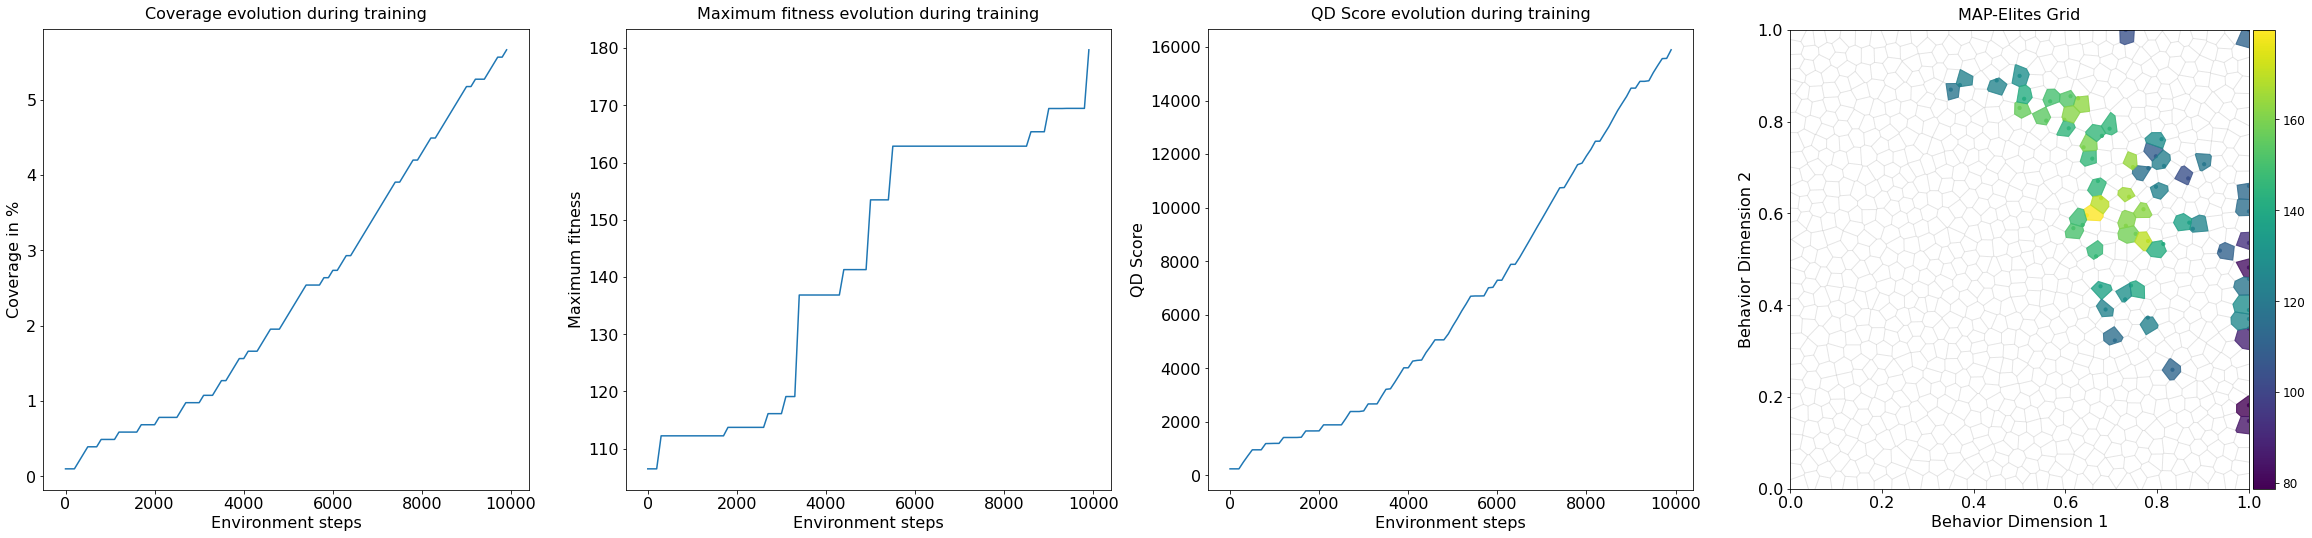

In [17]:
#@title Visualization

# create the x-axis array
env_steps = jnp.arange(num_iterations) * episode_length

# create the plots and the grid
fig, axes = plot_map_elites_results(env_steps=env_steps, metrics=all_metrics, repertoire=repertoire, min_bd=min_bd, max_bd=max_bd)